In [9]:
from kaveh.behavioral.oculomotor.session import session
from kaveh.toolbox import find_file
from neo.io import Spike2IO
from matplotlib import pyplot as plt
import numpy as np
import quantities as pq
import csv
import os
import fnmatch
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

In [10]:
def bin_error_dirs(error_dirs):
    '''
    Bin error directions: Bins start from 157.5 and increaments counter-clockwise every 45 degrees => 8 bins, 0 to 7
    '''
    bins = np.arange(-180 + 22.5, 180, 45)
    bin_ind = np.digitize(error_dirs , bins, right=True)
    bin_ind[bin_ind == 8] = 0
    return bin_ind


def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
    cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []

    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_count = cs_count*1.0/bin_times.size
            bin_cs_counts.append(cs_count)
        else:
            bin_cs_counts.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return bin_cs_counts


In [47]:
with open('../data/neurons_david_data_with_spike_train.csv', 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader))
file_names = np.array([fn[0] for fn in csv_content])

for i, fn in enumerate(file_names):
    print('{}: {}'.format(i, fn))

0: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2Adapt_BW5L_FW5LCFRDone.smr
1: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2PreAdaptCFRDone.smr
2: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pct.smr
3: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt30pct.smr
4: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_preadapt.smr
5: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pctB.smr
6: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_FW5L_BW5R_A.smr
7: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_pre.smr
8: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4Adapt_FW5L_BW5RCFR611sec.smr
9: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4PreAdaptCFRDone.smr
10: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directiona

In [48]:
f_index =[10, 12, 13, 16, 18, 19, 21, 23, 26, 28, 30, 31, 34, 41, 43, 45, 46, 86, 91, 94, 98]
# f_index = f_index + [57, 63, 65, 69, 71, 76, 78]
for i in f_index:
    print('{}: {}'.format(i, file_names[i]))

10: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directionaltest.smr
12: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_1dirtest.smr
13: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_2dirtest.smr
16: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K45/error_direction/K45_1_ErrorDirectionTest.smr
18: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K21/error_direction/K21_2_directionaltest.smr
19: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K69/error_direction/K69_1_DirTuning.smr
21: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K40/error_direction/K40_1_Dirtuning.smr
23: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K16/error_direction/K16_2_directionaltest.smr
26: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Step/S36/error_direction/S36_1_directionalt

In [33]:
david_neurons_source = '/mnt/data/temp/kaveh/david_neurons/'

with open('../data/david_neurs.csv', 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader))
neuron_names = np.array([fn[0].split('\t')[0].split('\t')[0] for fn in csv_content if fn[0][-1][-1] == '1'])

file_names = []
for nn in neuron_names:
    matches = []
    for root, dirnames, filenames in os.walk(david_neurons_source + nn):
        for filename in fnmatch.filter(filenames, '*.smr.pkl'):
            matches.append(os.path.join(root, filename))
    if matches:
        for ff in matches:
            if os.path.exists(ff+'.session.pkl'):
                file_names.append(os.path.basename(ff)[0:-4])
                
                

In [35]:
len(file_names)

158

In [14]:
for i,fn in enumerate(file_names):
    print('{}: {}'.format(i, fn))

0: P21_1 LFW5 RBW5 C.smr
1: P21_1 LBW5 RFW5 D.smr
2: P21_1 LBW5 RFW5 B.smr
3: P21_1 pre A.smr
4: P03_2 pre A.smr
5: P03_2 rbw5 lfw5 F.smr
6: P03_2 rbw5 lfw5 G.smr
7: P03_2 rfw5 lbw8 E.smr
8: P03_2 rbw5 lfw5 B.smr
9: P03_2 rfw5 lbw5 C.smr
10: P03_2 rfw8 lbw8 D.smr
11: P24_1 LFW1.5 RBW1.5 F.smr
12: P24_1 LFW5 RBW5 B.smr
13: P24_1 LFW1.5 RBW3.5 E.smr
14: P24_1 LFW5 RBW5 D.smr
15: P24_1 pre A.smr
16: P24_1 LBW5 RFW5 C.smr
17: P26_1_LFW5 RBW5 B.smr
18: P26_1 pre A.smr
19: O89_1LargeHor_c.smr
20: O22_2Adapt_BW5L_FW5LCFRDone.smr
21: O22_2PreAdaptCFRDone.smr
22: O13_3_preadapt.smr
23: O13_3_adapt40pctB.smr
24: O13_3_adapt30pct.smr
25: O13_3_adapt40pct.smr
26: O60_1_FW5L_BW5R_D.smr
27: O60_1_Preadapt.smr
28: O60_1_FW5L_BW5R_B.smr
29: O60_1_BW5L_FW5R_C.smr
30: O60_1_FW3L_BW3R_A.smr
31: O41_1_pre.smr
32: O41_1_FW5L_BW5R_A.smr
33: O29_4PreAdaptCFRDone.smr
34: O29_4Adapt_FW5L_BW5RCFR611sec.smr
35: O83_1_mix_N_FW5L_BW5R_A.smr
36: K14_1_directionaltest.smr
37: K14_1_errorsizetest.smr
38: K32_1control

In [49]:

f_name_session = find_file(os.path.basename('W120108_1634_Adapt.smr')+'.pkl.session.pkl', david_neurons_source)

print(f_name_session)

with open(f_name_session, 'rb') as input:
    try:
        mysess = pickle.load(input, encoding='latin1')
    except TypeError:
        mysess = pickle.load(input)

iss_range = pq.quantity.Quantity(0.025, 's')
iss_targets = []
iss_saccades = []
saccades_with_no_iss_target = []
for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
    iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                             mysess.target_onset_times > son - iss_range), 
                                              np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                             mysess.target_offset_times > soff - iss_range)))[0])
    if iss_targets[-1].size != 0:
        iss_saccades.append(i)
    if iss_targets[-1].size == 0:
        saccades_with_no_iss_target.append(i)

iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)

#     mysess._calc_error_vectors()
saccade_response_delays_to_target_presentation = []
saccade_delays_target_offset_times = []
for toff in mysess.target_offset_times[non_iss_target_jumps]:

    delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > toff)] - toff
    delay_to_next_target_jump = mysess.target_onset_times[non_iss_target_jumps][np.argmax(mysess.target_onset_times[non_iss_target_jumps] > toff)] - toff
    # Only consider reaction times that are less than 600ms and are occurring before the next target jump
    if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
        saccade_response_delays_to_target_presentation.append(delay_to_next_saccade)
        saccade_delays_target_offset_times.append(toff)

saccade_response_delays_to_target_presentation = np.squeeze(np.array(saccade_response_delays_to_target_presentation))
saccade_delays_target_offset_times = np.squeeze(np.array(saccade_delays_target_offset_times))

/mnt/data/temp/kaveh/david_neurons/W120108/W120108_1634_Adapt.smr.pkl.session.pkl


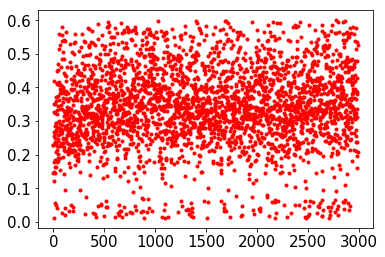

In [328]:
plt.figure()
plt.plot(saccade_response_delays_to_target_presentation, '.r')

In [322]:
np.argmax(mysess.saccade_onset_times > toff)

0

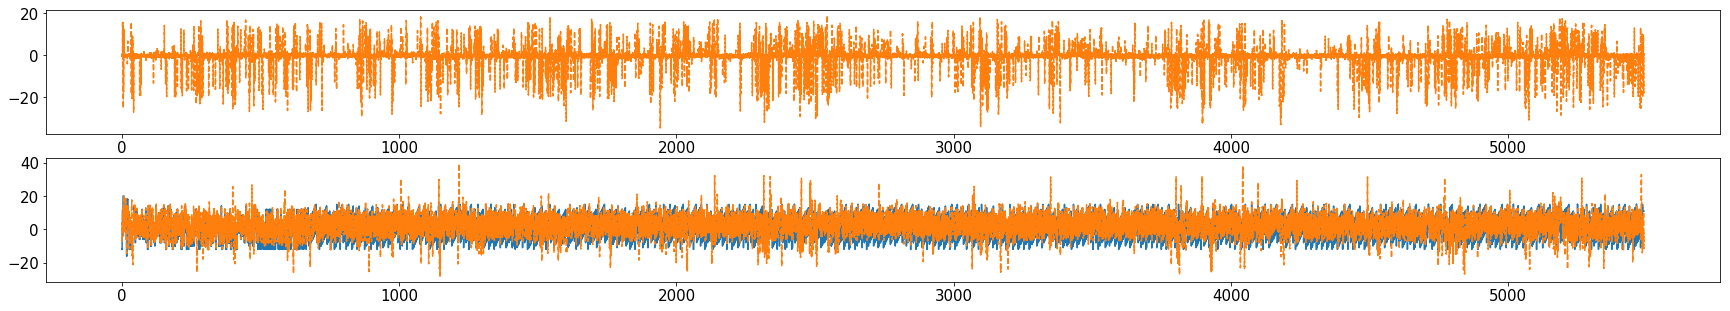

In [329]:
import gc
gc.collect()

plt.figure(figsize=(30,5))
ax1 = plt.subplot(211)
plt.plot(mysess.t_HT, mysess.HT)
plt.plot(mysess.t_HE, mysess.HE, '--')

ax2 = plt.subplot(212)
plt.plot(mysess.t_VT, mysess.VT)
plt.plot(mysess.t_VE, mysess.VE, '--')


In [23]:
file_names[f_index]

array(['/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directionaltest.smr',
       '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_1dirtest.smr',
       '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_2dirtest.smr',
       '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K45/error_direction/K45_1_ErrorDirectionTest.smr',
       '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K21/error_direction/K21_2_directionaltest.smr',
       '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K69/error_direction/K69_1_DirTuning.smr',
       '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K40/error_direction/K40_1_Dirtuning.smr',
       '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K16/error_direction/K16_2_directionaltest.smr',
       '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/200

In [50]:
import os
toffs_for_file = {}
sac_rxn_t_for_file = {}


for bf in file_names:
# for bf in file_names:
#     f_name = find_file(bf, '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
    
    
    f_name_session = find_file(os.path.basename(bf)+'.pkl.session.pkl', david_neurons_source)
    
    print(f_name_session)
    
    with open(f_name_session, 'rb') as input:
        try:
            mysess = pickle.load(input, encoding='latin1')
        except TypeError:
            mysess = pickle.load(input)
    # find inra-saccadic target jumps. For each saccade, check if that saccade is accompanied by a simultaneous target jump.
    # If so, it is an intra-saccadic target_jump. 
    # check 25 ms before and after the saccade onset and offset for the target jump onset and offset. if found, the target jump is intra-saccadic

    iss_range = pq.quantity.Quantity(0.025, 's')
    iss_targets = []
    iss_saccades = []
    saccades_with_no_iss_target = []
    for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
        iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                                 mysess.target_onset_times > son - iss_range), 
                                                  np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                                 mysess.target_offset_times > soff - iss_range)))[0])
        if iss_targets[-1].size != 0:
            iss_saccades.append(i)
        if iss_targets[-1].size == 0:
            saccades_with_no_iss_target.append(i)

    iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

    non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)

#     mysess._calc_error_vectors()
    saccade_response_delays_to_target_presentation = []
    saccade_delays_target_offset_times = []
    for toff in mysess.target_offset_times[non_iss_target_jumps]:
        
        delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > toff)] - toff
        delay_to_next_target_jump = mysess.target_onset_times[non_iss_target_jumps][np.argmax(mysess.target_onset_times[non_iss_target_jumps] > toff)] - toff
        # Only consider reaction times that are less than 600ms and are occurring before the next target jump
        if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
            saccade_response_delays_to_target_presentation.append(delay_to_next_saccade)
            saccade_delays_target_offset_times.append(toff)

    saccade_response_delays_to_target_presentation = np.squeeze(np.array(saccade_response_delays_to_target_presentation))
    saccade_delays_target_offset_times = np.squeeze(np.array(saccade_delays_target_offset_times))
    
    toffs_for_file[bf] = saccade_delays_target_offset_times
    sac_rxn_t_for_file[bf] = saccade_response_delays_to_target_presentation

/mnt/data/temp/kaveh/david_neurons/O22/O22_2Adapt_BW5L_FW5LCFRDone.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/O22/O22_2PreAdaptCFRDone.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/O13/O13_3_adapt40pct.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/O13/O13_3_adapt30pct.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/O13/O13_3_preadapt.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/O13/O13_3_adapt40pctB.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/O41/O41_1_FW5L_BW5R_A.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/O41/O41_1_pre.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/O29/O29_4Adapt_FW5L_BW5RCFR611sec.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/O29/O29_4PreAdaptCFRDone.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/K14/error_direction/K14_1_directionaltest.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/K14/error_magnitude/K14_1_errorsizetest.smr.pkl.session.pkl
/mnt/data/temp/kaveh/da

ValueError: could not find F090606_1325_Adapt.smr.pkl.session.pkl in /mnt/data/temp/kaveh/david_neurons/

In [ ]:
hists = []
for rt in sac_rxn_t_for_file.values():
    hs, bins = np.histogram(rt, bins = np.arange(0,0.6 , 0.01))
    hists.append(hs*1.0/np.sum(hs))
hists = np.array(hists)

In [ ]:
hists = np.delete(hists, np.where(np.any(np.isnan(hists), axis = 1)), axis=0)

In [ ]:
hists = np.delete(hists, np.where(np.max(hists, axis = 1) > 0.45), axis = 0)

In [ ]:
center = (bins[:-1] + bins[1:]) / 2

In [ ]:
meanhs = np.mean(hists, axis = 0)
sehs = np.std(hists, axis = 0)/np.sqrt(hists.shape[0]-1)
sdhs = np.std(hists, axis = 0)

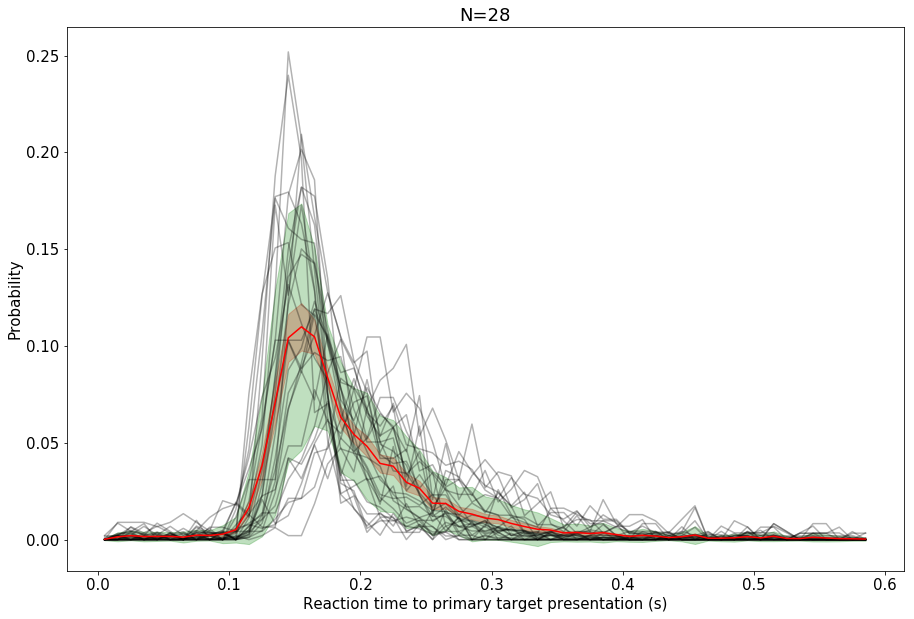

In [343]:
plt.figure(figsize=(15,10))
plt.plot(center, hists.T, color='k' ,alpha = 0.3)
plt.plot(center, np.mean(hists, axis=0), color='r')
plt.fill_between(center, meanhs - sehs, meanhs + sehs, color='r', alpha=0.25)
plt.fill_between(center, meanhs - sdhs, meanhs + sdhs, color='g', alpha=0.25)

plt.xlabel('Reaction time to primary target presentation (s)', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title('N={}'.format(hists.shape[0]))
plt.savefig('../data/plots/saccade_reaction_time_hist.png')

Text(0,0.5,u'Probability')

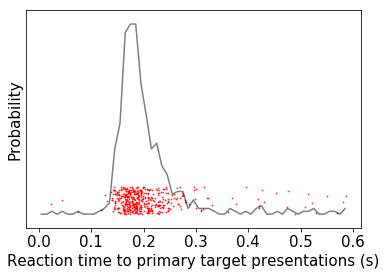

In [295]:
plt.figure()
plt.plot(rt,np.zeros(rt.size)+ 0.02*np.random.random(rt.size), '.r',markersize=1.5, alpha = 0.8)
plt.ylim([-0.01,np.max(hists[-1]+0.01)])
plt.yticks([])
plt.plot(center, hists[-1], 'k', alpha = 0.5)
plt.xlabel('Reaction time to primary target presentations (s)')
plt.ylabel('Probability')

In [414]:
# Save histogram plots of reaction time for each file
for (fn,rt) in zip(sac_rxn_t_for_file.keys(),sac_rxn_t_for_file.values()):
    print(fn)
    hs, bins = np.histogram(rt, bins = np.arange(0,0.6 , 0.01))
    hs = (hs*1.0/np.sum(hs))
    if np.logical_and(~np.any(np.isnan(hs)), np.max(hs) <= 0.45):
    
        plt.figure()
        plt.plot(rt,np.zeros(rt.size)+ 0.02*np.random.random(rt.size), '.r',markersize=1.5, alpha = 0.8)
        plt.ylim([-0.01,np.max(hs)+0.1])
        
        plt.plot(center, hs, 'k', alpha = 0.5)
        plt.xlabel('Reaction time to primary target presentations (s)')
        plt.ylabel('Probability')
        plt.title(fn)
        plt.savefig('../data/plots/reaction_times/with_cs_detected/'+os.path.basename(fn)+'.png')
        plt.close()


/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directionaltest.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K69/error_direction/K69_1_DirTuning.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091908_1/B091908_1_1500_List.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K21/error_direction/K21_2_directionaltest.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W091208/W091208_1337_List.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_2dirtest.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W120508_2/W120508_2_1628_List.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K40/error_direction/K40_1_Dirtuning.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Step/S34/error_direction/S34_1_directionaltuning.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010

In [51]:
# Save mean reaction time histogram for each monkey
hists_for_monkey = {}
rts_for_monkey = {}
toffs_for_file_processed = {}
for (fn,rt,fn2,toffs) in zip(sac_rxn_t_for_file.keys(),sac_rxn_t_for_file.values(),toffs_for_file.keys(),toffs_for_file.values()):
    print(fn)
    print(fn2)
    hs, bins = np.histogram(rt, bins = np.arange(0,0.6 , 0.01))

    hs = (hs*1.0/np.sum(hs))
    
    if np.logical_and(~np.any(np.isnan(hs)), np.max(hs) <= 0.45):
        toffs_for_file_processed[fn2] = toffs
        key = os.path.basename(fn)[0]
        if key in hists_for_monkey.keys():
            mlist = hists_for_monkey[key]
            mlist.append(hs)
            hists_for_monkey[key]= mlist
        else:
            hists_for_monkey[key] = [hs]

        if key in rts_for_monkey.keys():
            mlist = rts_for_monkey[key]
            mlist.append(rt)
            rts_for_monkey[key]= mlist
        else:
            rts_for_monkey[key] = [rt]


/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W120508_2/W120508_2_1548_Adapt.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W120508_2/W120508_2_1548_Adapt.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W091208/W091208_1348_Adapt.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W091208/W091208_1348_Adapt.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_magnitude/K33_2Herrortest.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_magnitude/K33_2Herrortest.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directionaltest.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directionaltest.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pct.smr
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pct.smr
/mnt/pap

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


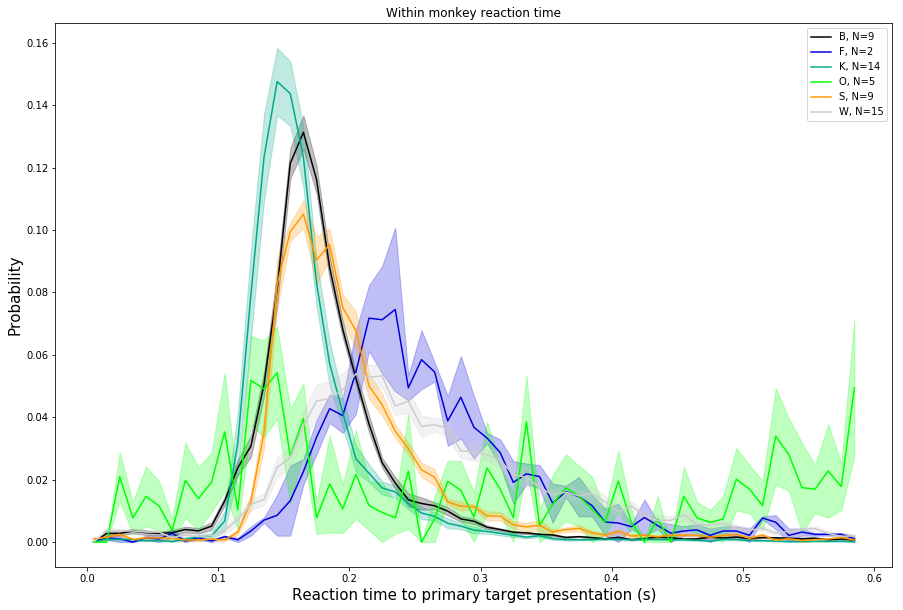

In [52]:
plt.figure(figsize=(15,10))
colors = plt.cm.nipy_spectral(np.linspace(0,1,len(hists_for_monkey.keys())))
i=0
for monkey, hists in zip(hists_for_monkey.keys(), hists_for_monkey.values()):
#     print(np.percentile(hists))
    hists = np.array(hists)
    center = (bins[:-1] + bins[1:]) / 2
    meanhs = np.mean(hists, axis = 0)
    sehs = np.std(hists, axis = 0)/np.sqrt(hists.shape[0]-1)
    sdhs = np.std(hists, axis = 0)
#     plt.plot(center, hists.T, color='k' ,alpha = 0.3)
    plt.plot(center, np.mean(hists, axis=0), color=colors[i], label = '{}, N={}'.format(monkey,hists.shape[0]))
    plt.fill_between(center, meanhs - sehs, meanhs + sehs, color=colors[i], alpha=0.25)
    i = i+1
#     plt.fill_between(center, meanhs - sdhs, meanhs + sdhs, color='g', alpha=0.25)

plt.xlabel('Reaction time to primary target presentation (s)', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title('Within monkey reaction time')
plt.legend()
# plt.savefig('../data/plots/reaction_times/monkey_averages/within_monkey_reaction_time.png')
# plt.savefig('../data/plots/reaction_times/monkey_averages/within_monkey_reaction_time.svg')
plt.show()
    

In [486]:
np.percentile(np.hstack(rts_for_monkey['W']),50)

0.21996000000000038

In [53]:
# bin based on quartile
bin_edges_for_monkey = {}
for monkey in rts_for_monkey.keys():
    bin_edges_for_monkey[monkey] = [np.percentile(np.hstack(rts_for_monkey[monkey]),q) for q in [25, 50, 75]]
    
# bin_ind_rt = np.digitize(rts_for_monkey['W'][0], bins = bin_edges)


In [56]:
cs_counts_for_file = {}
cs_probs_for_file = {}
bin_sizes_for_file = {}
for f_name, toff in zip(toffs_for_file_processed.keys(), toffs_for_file_processed.values()):
    print(f_name)
    f_name_csv = find_file(os.path.basename(f_name)+'.pkl.GMM.CS.csv', david_neurons_source)
    
    neo_reader = Spike2IO(filename=f_name)
    neo_data = neo_reader.read()
    data_block = neo_data[0]
    seg = data_block.segments[0]

    # Load cs times from csGUI csv files
    import csv
    t_signal = seg.analogsignals[-1].times

    with open(f_name_csv, 'r') as csv_f:
        reader = csv.reader(csv_f)
        csv_content = np.array(list(reader), dtype=np.int64)

    cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
    cs_times = t_signal[cs_indices]
#     cs_times.shape
    bin_ind_sac_delays = np.digitize(sac_rxn_t_for_file[f_name], bins = bin_edges_for_monkey[os.path.basename(f_name)[0]])
    print(bin_ind_sac_delays)
    (cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.200, toff, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)
    cs_counts_for_file[f_name] = cs_counts
    cs_probs_for_file[f_name] = cs_probs
    bin_sizes_for_file[f_name] = bin_sizes

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W120508_2/W120508_2_1548_Adapt.smr
[2 1 0 ... 1 1 0]
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W091208/W091208_1348_Adapt.smr
[0 1 0 ... 0 2 3]
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_magnitude/K33_2Herrortest.smr
[0 0 0 0 0 0 3 0 0 0 0 1 0 1 3 3 0 1 0 0 2 0 2 0 0 0 0 1 0 0 1 1 0 1 3 0 0
 2 3 0 1 0 0 0 0 2 2 1 1 0 0 2 0 0 3 3 0 0 1 0 0 0 0 0 0 1 1 2 2 0 0 0 0 0
 0 0 0 0 0 2 0 1 0 3 0 0 0 2 0 0 0 0 0 0 3 0 0 0 0 0 1 0 0 0 2 0 1 1 1 0 2
 0 1 0 1 2 3 0 0 0 0 0 2 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 2 0 0 0 0 0 0 0
 0 3 1 0 0 1 0 0 3 0 0 0 3 0 0 0 0 3 0 0 0 2 0 0 1 0 0 1 0 0 1 0 3 0 3 2 0
 0 1 0 3 0 0 0 0 0 1 0 0 0 0 0 1 2 0 1 0 1 1 3 0 0 2 0 1 0 0 1 0 0 0 1 0 0
 1 0 3 0 0 1 0 2 0 0 0 1 0 0 0 3 1 0 3 0 0 0 0 0 0 1 3 0 3 0 0 1 0 3 0 0 0
 0 0 0 0 2 0 0 2 0 1 0 1 3 1 0 3 1 1 1 0 0 0 0 0 0 0 0 0 2 0 2 0 3 0 2 0 0
 0 0 0 0 0 0 1 0 2 0 0 0 0 3 0 0 2 0 1 0 3 0 1 2 0 3 3 0 0 3 0 

ValueError: could not find K45_1_ErrorSizetest315degDir.smr.pkl.GMM.CS.csv in /mnt/data/temp/kaveh/david_neurons/

In [ ]:
cs_probs_for_file.values()

In [ ]:
mean_cs_prob = np.mean(np.vstack(cs_probs_for_file.values()),axis=0)
se_cs_prob = np.std(np.vstack(cs_probs_for_file.values()),axis=0)/np.sqrt(27)


In [ ]:
plt.figure(figsize=(10,8))
plt.plot([1,2,3,4], mean_cs_prob, color='r')
plt.fill_between([1,2,3,4], mean_cs_prob - se_cs_prob, mean_cs_prob + se_cs_prob, color='r', alpha=0.25)
plt.xticks([1,2,3,4])
plt.ylabel('CS probability')
plt.xlabel('nth Quartile')
# plt.savefig('../data/plots/reaction_times/with_cs_detected/cs_tuning_quartile.png')

In [26]:
for monkey, qt in zip(bin_edges_for_monkey.keys(), bin_edges_for_monkey.values()):
    print('Quartile edges for monkey {}: {}'.format(monkey, qt))

Quartile edges for monkey K: [0.14795999999995502, 0.16295999999999822, 0.18695999999999913]
Quartile edges for monkey B: [0.14395999999999276, 0.156959999999998, 0.17296000000000333]
Quartile edges for monkey S: [0.16295999999999822, 0.18495999999998958, 0.21695999999999316]
Quartile edges for monkey W: [0.17995999999999412, 0.21996000000000038, 0.27995999999996]
Quartile edges for monkey F: [0.15896000000003596, 0.19595999999999947, 0.23796000000000106]


In [55]:
import quantities as pq

def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
#     cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)